# Analysis of SEIRX model runs for test technology and vaccination ratios

In [1]:
import pandas as pd
import numpy as np
from os.path import join
import analysis_functions as af

In [2]:
language = 'english' # English or German
# vaccination ratios of (employee, resident) groups corresponding to the
# different vaccination scenarios
vaccination_scenarios = [(0, 0), (0.5, 0.0), (0.0, 0.5), (0.5, 0.9), (0.9, 0.9)]

In [3]:
# get the right plot labels given the language
test_name_map = af.label_map[language]['test_name_map']
frequency_name_map = af.label_map[language]['frequency_name_map']

if language == 'english':
    screening_intervals = ['never', 'once\na week', 'twice\na week', 
                           '3 times\na week']
    
    vacc_scenario_labels = ['no\nvaccination', 'emp. 50%\nres. 0%', 
                            'emp. 0%\nres. 50%',  'emp. 50%\nres. 90%',
                             'emp. 90%\nres. 90%']
    
    test_strat_labels = ['testing employees 2x/week',
                         'testing everyone 1x/week',
                         'no testing']
if language == 'german':
    screening_intervals = ['nie', 'ein mal\npro Woche', '2 mal\npro Woche',
                           '3 mal\npro Woche']

    vacc_scenario_labels = ['keine\nImpfungen', 'Mit. 50%\nBew. 0%', 
                            'Mit. 0%\nBew. 50%',  'Mit. 50%\nBew. 90%',
                             'Mit. 90%\Bew. 90%']
    
    test_strat_labels = ['Testen MitarbeiterInnen 2x/Woche',
                         'Testen alle 1x/Woche',
                         'keine Tests']
    


## Analysis B.1.1.7

### Violin plots

#### Load simulation results

In [4]:
test_types = ['same_day_antigen', 'same_day_PCR', None]
index_cases = ['employee', 'resident']
vaccination_scenarios_and_labels = [
                         (0.5, 0.0, vacc_scenario_labels[1]),
                         (0.0, 0.5, vacc_scenario_labels[2]),
                         (0.5, 0.9, vacc_scenario_labels[3]),
                         #(0.9, 0.9, vacc_scenario_labels[3])
                        ]

testing_strats = [(3, None, test_strat_labels[0]),
                     (7, 7, test_strat_labels[1])]

testing_scenarios = np.asarray([
        test_strat_labels[0] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[0] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[2] + '\n' + test_name_map[test_types[2]]])

In [5]:
# load the vaccination scenario X testing strategy data
ensmbl_src = '../data/simulation_results/ensembles/testing_and_vaccination'
params = [(t, i, j, k, l, m, n, o) \
             for t in test_types[0:2]
             for i in index_cases\
             for j, k, l in testing_strats\
             for m, n, o in vaccination_scenarios_and_labels]

ensmbls = pd.DataFrame()
for p in params:
    ensmbls = pd.concat([ensmbls, 
            af.load_ensmbl(p, test_name_map, ensmbl_src, variant='UK_variant')])

In [6]:
# load the baseline data (only testing strategies)
ensmbl_src = '../data/simulation_results/ensembles/testing_strategy'
params = [(t, i, j, k, l, vacc_scenario_labels[0]) \
          for t in test_types[0:2]\
          for i in index_cases\
          for j, k, l in testing_strats]

baseline_ensmbls = pd.DataFrame()
for p in params:
    baseline_ensmbls = pd.concat([baseline_ensmbls, 
                        af.load_baseline_ensmbl(p, test_name_map,
                                    ensmbl_src, variant='UK_variant')])

In [7]:
# load the data without testing
ensmbl_src = '../data/simulation_results/ensembles/vaccination/'
params = [(None, i, None, None, test_strat_labels[2], j, k, l) \
          for i in index_cases \
          for j, k, l in vaccination_scenarios_and_labels]

no_test_ensmbls = pd.DataFrame()
for p in params:
    no_test_ensmbls = pd.concat([no_test_ensmbls, 
        af.load_no_test_ensmbl(p, test_name_map, ensmbl_src, variant='UK_variant')])

In [8]:
# load the data without testing and vaccinations
ensmbl_src = '../data/simulation_results/ensembles/TTI'
params = [(None, i, None, None, test_strat_labels[2], 0, 0, vacc_scenario_labels[0]) \
          for i in index_cases]

TTI_ensmbl = pd.DataFrame()
for p in params:
    TTI_ensmbl = pd.concat([TTI_ensmbl, 
                    af.load_TTI_ensmbl(p, ensmbl_src, variant='UK_variant')])


In [9]:
ensmbls = pd.concat([ensmbls, baseline_ensmbls,
                     no_test_ensmbls, TTI_ensmbl])

#### Plots

**Testing scenarios**
* Employees screened 2x / week with antigen tests, residents never
* Employees screened 2x / week with PCR tests, residents never
* No testing

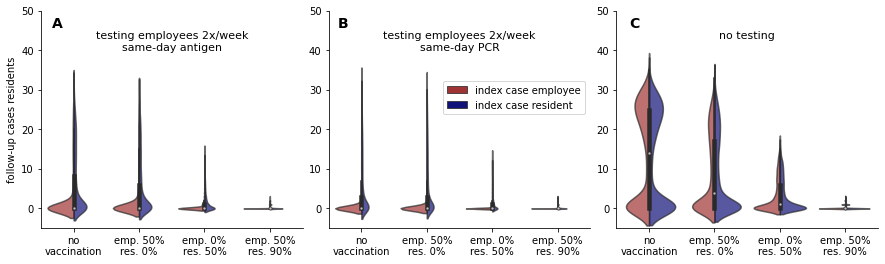

In [10]:
af.plot_violins2(ensmbls, 'infected_residents', testing_scenarios[[0, 1, 4]],
            vacc_scenario_labels[0:4], language, ymin=-5, ymax=50,
            variant='_UK_variant')

**Testing**
* Employees screened 2x / week with antigen tests, residents never
* Employees screened 2x / week with PCR tests, residents never
* Employees screened 1x / week, residents screened 1x / week, both with antigen tests
* Employees screened 1x / week, residents screened 1x / week, both with PCR tests

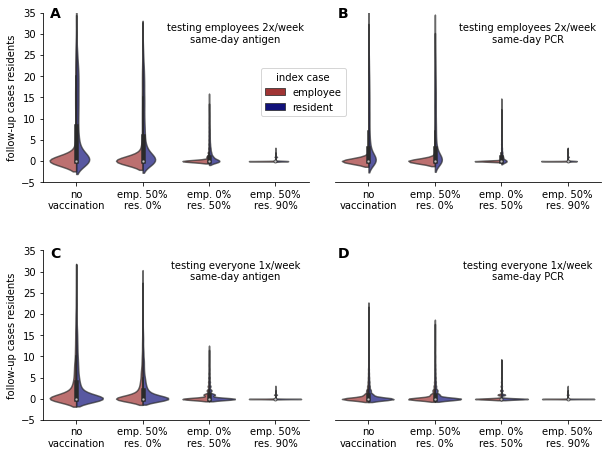

In [11]:
af.plot_violins(ensmbls, 'infected_residents', testing_scenarios[0:4],
             vacc_scenario_labels[0:4], language, ymin=-5, ymax=35,
             variant='_UK_variant')

### Colormaps for different vaccination scenarios

#### Load the simulation results

In [12]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_UK_variant_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [13]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [14]:
N_runs = 5000
sim_name = 'simulations_testing_strategy_UK_variant_{}.csv'.format(N_runs)

In [15]:
no_vacc_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_vacc_data['resident_screen_interval'] = no_vacc_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_screen_interval'] = no_vacc_data['employee_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_vaccination_ratio'] = 0.0
no_vacc_data['resident_vaccination_ratio'] = 0.0

no_vacc_data = no_vacc_data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [16]:
data = pd.concat([data, no_vacc_data])

In [17]:
N_runs = 5000
sim_name = 'simulations_vaccination_rate_UK_variant_{}.csv'.format(N_runs)

In [18]:
no_test_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_test_data['resident_screen_interval'] = no_test_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_test_data['employee_screen_interval'] = no_test_data['employee_screen_interval']\
    .replace(frequency_name_map)

no_test_data = no_test_data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

#### Plots

In [20]:
from importlib import reload
reload(af)

<module 'analysis_functions' from '/home/jana/Projects/COVID_nursing_homes/analysis/code/analysis_functions.py'>

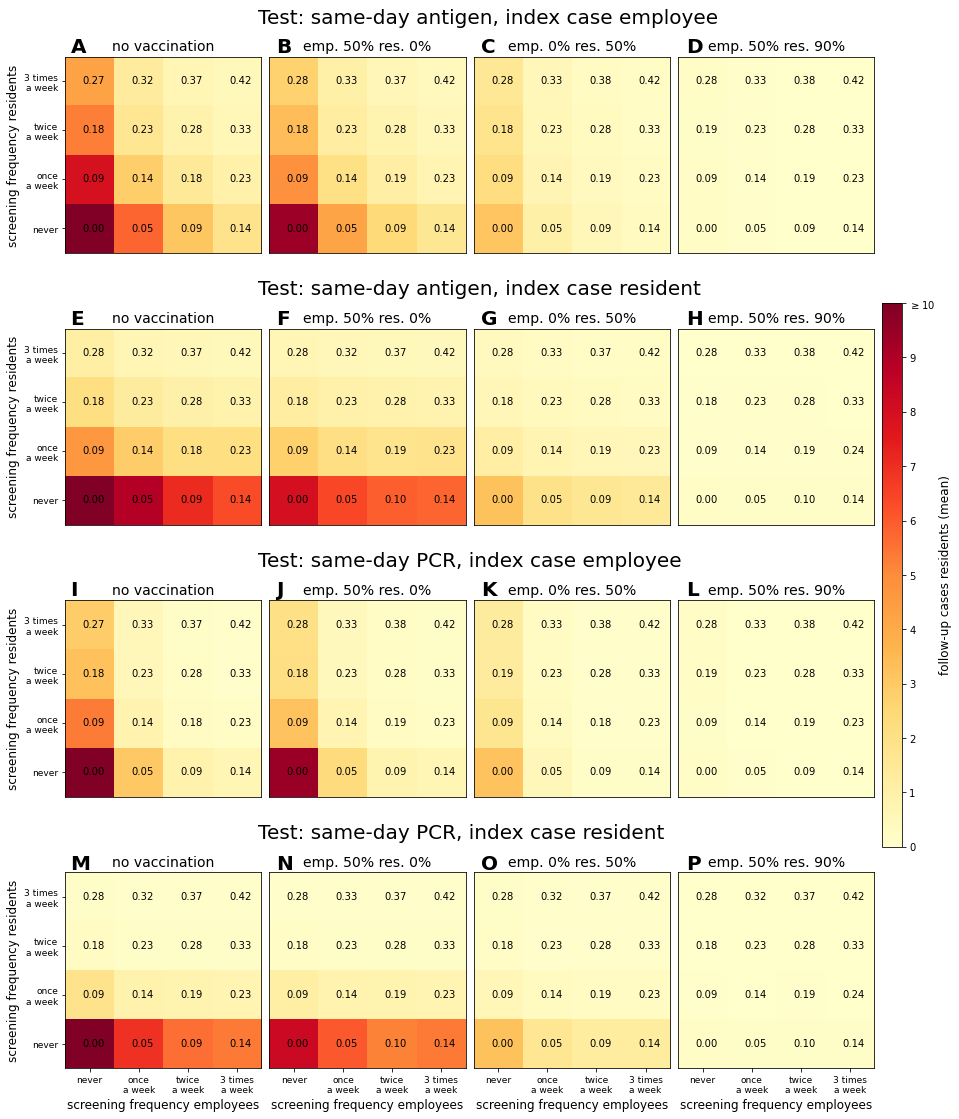

In [21]:
af.plot_testing_strategy_vaccination_scenario_grid(\
    data, 'infected_residents_mean', screening_intervals,
    vaccination_scenarios[0:4], vacc_scenario_labels, language,
    variant='_UK_variant', vmax=10, vstep=1)

### Outbreak sizes

#### Antigen tests & 50% vaccinated residents

In [42]:
mean = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.523 +- 1.5174753857342338


In [43]:
mean = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.62 +- 2.472169558194764


#### PCR tests & 0% vaccinated residents, 0% vaccinated employees

In [44]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9206 +- 3.623661383789174


In [45]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.6054 +- 7.259933344489693


#### PCR tests & 0% vaccinated residents, 50% vaccinated employees

In [46]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.783 +- 3.2371603051699918


In [47]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.2024 +- 6.867143931297394


#### PCR tests & 50% vaccinated residents

In [48]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9206 +- 3.623661383789174


In [49]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.2726000000000002 +- 2.0252183936327413


#### No tests & 90% vaccinated residents, 50% vaccinated employees

In [54]:
mean = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_mean']
std = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1744 +- 0.4508051519858789


In [55]:
mean = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_mean'] - 1
std = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.19619999999999993 +- 0.4772327631481774


#### Antigen tests & 90% vaccinated residents, 50% vaccinated employees

In [52]:
mean = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0376 +- 0.2063849775341954


In [56]:
mean = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.14280000000000004 +- 0.3990488792135624


#### PCR tests & 90% vaccinated residents, 50% vaccinated employees

In [57]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.016 +- 0.1376509700580115


In [58]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1412 +- 0.4006178464968658


## Analysis wild type

In [59]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [60]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

### Violin plots

**Realistic scenarios**
* Employees screened 2x / week, residents never, index resident
* Employees screened 2x / week, residents never, index employee
* Employees screened 1x / week, residents screened 1x / week, index resident
* Employees screened 1x / week, residents screened 1x / week, index employee

#### Load simulation results

In [61]:
test_types = ['same_day_antigen', 'same_day_PCR', None]
index_cases = ['employee', 'resident']
vaccination_scenarios_and_labels = [
                         (0.5, 0.0, vacc_scenario_labels[1]),
                         (0.0, 0.5, vacc_scenario_labels[2]),
                         (0.5, 0.9, vacc_scenario_labels[3]),
                         #(0.9, 0.9, vacc_scenario_labels[3])
                        ]

testing_strats = [(3, None, test_strat_labels[0]),
                     (7, 7, test_strat_labels[1])]

testing_scenarios = np.asarray([
        test_strat_labels[0] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[0] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[2] + '\n' + test_name_map[test_types[2]]])

In [62]:
# load the vaccination scenario X testing strategy data
ensmbl_src = '../data/simulation_results/ensembles/testing_and_vaccination'
params = [(t, i, j, k, l, m, n, o) \
             for t in test_types[0:2]
             for i in index_cases\
             for j, k, l in testing_strats\
             for m, n, o in vaccination_scenarios_and_labels]

ensmbls = pd.DataFrame()
for p in params:
    ensmbls = pd.concat([ensmbls, 
            af.load_ensmbl(p, test_name_map, ensmbl_src)])

In [63]:
# load the baseline data (only testing strategies)
ensmbl_src = '../data/simulation_results/ensembles/testing_strategy'
params = [(t, i, j, k, l, vacc_scenario_labels[0]) \
          for t in test_types[0:2]\
          for i in index_cases\
          for j, k, l in testing_strats]

baseline_ensmbls = pd.DataFrame()
for p in params:
    baseline_ensmbls = pd.concat([baseline_ensmbls, 
                        af.load_baseline_ensmbl(p, test_name_map,
                                    ensmbl_src)])

In [64]:
# load the data without testing
ensmbl_src = '../data/simulation_results/ensembles/vaccination/'
params = [(None, i, None, None, test_strat_labels[2], j, k, l) \
          for i in index_cases \
          for j, k, l in vaccination_scenarios_and_labels]

no_test_ensmbls = pd.DataFrame()
for p in params:
    no_test_ensmbls = pd.concat([no_test_ensmbls, 
        af.load_no_test_ensmbl(p, test_name_map, ensmbl_src)])

In [65]:
# load the data without testing and vaccinations
ensmbl_src = '../data/simulation_results/ensembles/TTI'
params = [(None, i, None, None, test_strat_labels[2], 0, 0, vacc_scenario_labels[0]) \
          for i in index_cases]

TTI_ensmbl = pd.DataFrame()
for p in params:
    TTI_ensmbl = pd.concat([TTI_ensmbl, 
                    af.load_TTI_ensmbl(p, ensmbl_src)])


In [66]:
ensmbls = pd.concat([ensmbls, baseline_ensmbls,
                     no_test_ensmbls, TTI_ensmbl])

#### Plots

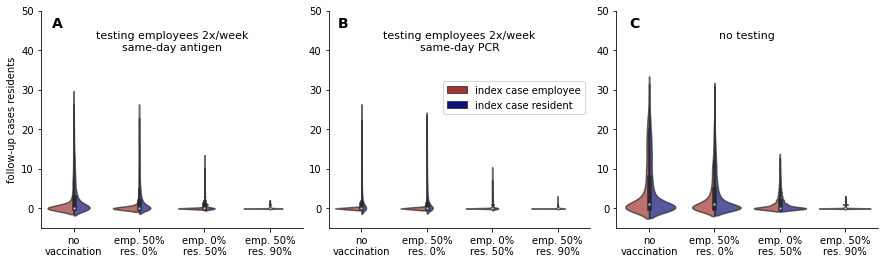

In [67]:
af.plot_violins2(ensmbls, 'infected_residents', testing_scenarios[[0, 1, 4]],
            vacc_scenario_labels[0:4], language, ymin=-5, ymax=50,
            variant='')

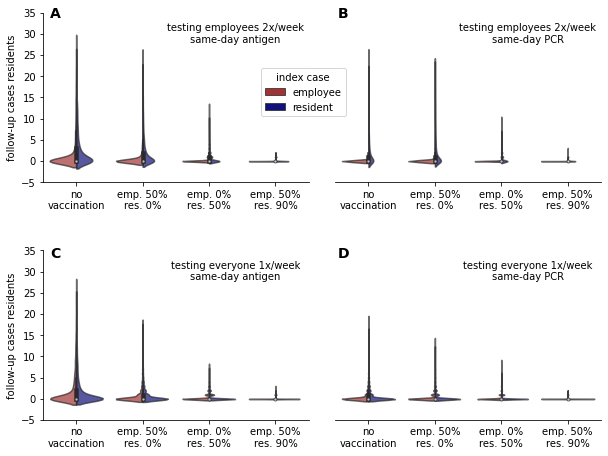

In [68]:
af.plot_violins(ensmbls, 'infected_residents', testing_scenarios[0:4],
             vacc_scenario_labels[0:4], language, ymin=-5, ymax=35)

### Colormaps for different vaccination scenarios

In [69]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [70]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [71]:
N_runs = 5000
sim_name = 'simulations_testing_strategy_{}.csv'.format(N_runs)

In [72]:
no_vacc_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_vacc_data['resident_screen_interval'] = no_vacc_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_screen_interval'] = no_vacc_data['employee_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_vaccination_ratio'] = 0.0
no_vacc_data['resident_vaccination_ratio'] = 0.0

no_vacc_data = no_vacc_data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [73]:
data = pd.concat([data, no_vacc_data])

In [74]:
N_runs = 5000
sim_name = 'simulations_vaccination_rate_{}.csv'.format(N_runs)

In [75]:
no_test_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_test_data['resident_screen_interval'] = no_test_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_test_data['employee_screen_interval'] = no_test_data['employee_screen_interval']\
    .replace(frequency_name_map)

no_test_data = no_test_data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

#### Plots

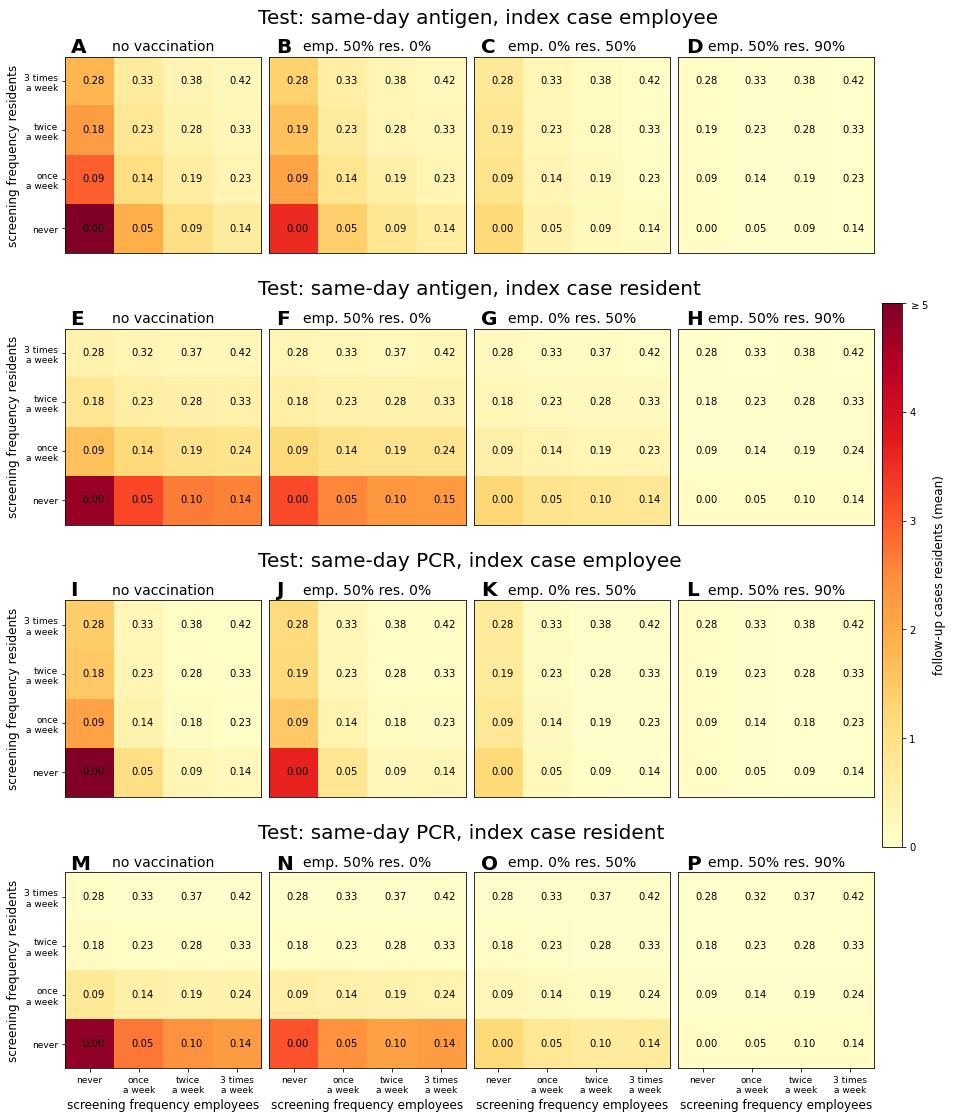

In [76]:
af.plot_testing_strategy_vaccination_scenario_grid(\
    data, 'infected_residents_mean', screening_intervals,
    vaccination_scenarios[0:4], vacc_scenario_labels, language,
    vmax=5, vstep=1)

### Outbreak sizes

#### Antigen tests & 50% vaccinated residents

In [77]:
mean = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2352 +- 0.7954919996482057


In [78]:
mean = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.8282 +- 1.4547535948071484


#### PCR tests & 0% vaccinated residents, 0% vaccinated employees

In [79]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3218 +- 1.5745286876134152


In [80]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.408 +- 3.909039794939888


#### PCR tests & 0% vaccinated residents, 50% vaccinated employees

In [81]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.272 +- 1.3468403007629195


In [82]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.1508 +- 3.43779333942704


#### PCR tests & 50% vaccinated residents

In [83]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3218 +- 1.5745286876134152


In [84]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6941999999999999 +- 1.2437828424414892


#### PCR tests & 90% vaccinated residents, 50% vaccinated employees

In [85]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0096 +- 0.0975179057834492


In [86]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.08939999999999992 +- 0.3146862651738996


#### Antigen tests & 90% vaccinated residents, 50% vaccinated employees

In [87]:
mean = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.022 +- 0.1533646117617365


In [88]:
mean = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0915999999999999 +- 0.308591130295638


#### No tests & 90% vaccinated residents, 50% vaccinated employees

In [89]:
mean = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_mean']
std = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1004 +- 0.3363665686326432


In [90]:
mean = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_mean'] - 1
std = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.11220000000000008 +- 0.3453042238395011


## Analysis B.1.1.7 & employee masks

### Violin plots

#### Load simulation results

In [91]:
test_types = ['same_day_antigen', 'same_day_PCR', None]
index_cases = ['employee', 'resident']
vaccination_scenarios_and_labels = [
                         (0.5, 0.0, vacc_scenario_labels[1]),
                         (0.0, 0.5, vacc_scenario_labels[2]),
                         (0.5, 0.9, vacc_scenario_labels[3]),
                         #(0.9, 0.9, vacc_scenario_labels[3])
                        ]

testing_strats = [(3, None, test_strat_labels[0]),
                     (7, 7, test_strat_labels[1])]

testing_scenarios = np.asarray([
        test_strat_labels[0] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[0] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[2] + '\n' + test_name_map[test_types[2]]])

In [92]:
# load the vaccination scenario X testing strategy data
ensmbl_src = '../data/simulation_results/ensembles/testing_and_vaccination'
params = [(t, i, j, k, l, m, n, o) \
             for t in test_types[0:2]
             for i in index_cases\
             for j, k, l in testing_strats\
             for m, n, o in vaccination_scenarios_and_labels]

ensmbls = pd.DataFrame()
for p in params:
    ensmbls = pd.concat([ensmbls, 
            af.load_ensmbl(p, test_name_map, ensmbl_src, variant='masks')])

In [93]:
# load the baseline data (only testing strategies)
ensmbl_src = '../data/simulation_results/ensembles/testing_strategy'
params = [(t, i, j, k, l, vacc_scenario_labels[0]) \
          for t in test_types[0:2]\
          for i in index_cases\
          for j, k, l in testing_strats]

baseline_ensmbls = pd.DataFrame()
for p in params:
    baseline_ensmbls = pd.concat([baseline_ensmbls, 
                        af.load_baseline_ensmbl(p, test_name_map,
                                    ensmbl_src, variant='masks')])

In [94]:
# load the data without testing
ensmbl_src = '../data/simulation_results/ensembles/vaccination/'
params = [(None, i, None, None, test_strat_labels[2], j, k, l) \
          for i in index_cases \
          for j, k, l in vaccination_scenarios_and_labels]

no_test_ensmbls = pd.DataFrame()
for p in params:
    no_test_ensmbls = pd.concat([no_test_ensmbls, 
        af.load_no_test_ensmbl(p, test_name_map, ensmbl_src, variant='masks')])

In [95]:
# load the data without testing and vaccinations
ensmbl_src = '../data/simulation_results/ensembles/TTI'
params = [(None, i, None, None, test_strat_labels[2], 0, 0, vacc_scenario_labels[0]) \
          for i in index_cases]

TTI_ensmbl = pd.DataFrame()
for p in params:
    TTI_ensmbl = pd.concat([TTI_ensmbl, 
                    af.load_TTI_ensmbl(p, ensmbl_src, variant='masks')])


In [96]:
ensmbls = pd.concat([ensmbls, baseline_ensmbls,
                     no_test_ensmbls, TTI_ensmbl])

#### Plots

**Testing scenarios**
* Employees screened 2x / week with antigen tests, residents never
* Employees screened 2x / week with PCR tests, residents never
* No testing

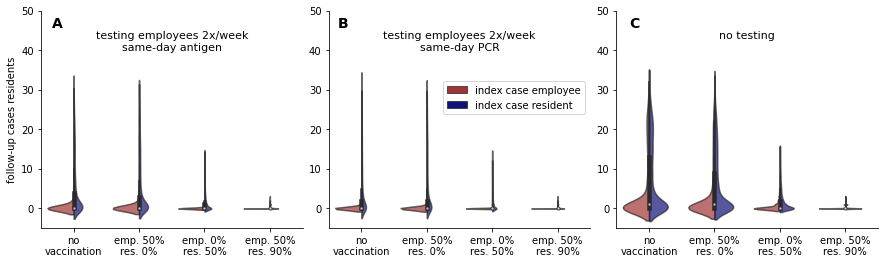

In [97]:
af.plot_violins2(ensmbls, 'infected_residents', testing_scenarios[[0, 1, 4]],
            vacc_scenario_labels[0:4], language, ymin=-5, ymax=50,
            variant='_masks')

**Testing**
* Employees screened 2x / week with antigen tests, residents never
* Employees screened 2x / week with PCR tests, residents never
* Employees screened 1x / week, residents screened 1x / week, both with antigen tests
* Employees screened 1x / week, residents screened 1x / week, both with PCR tests

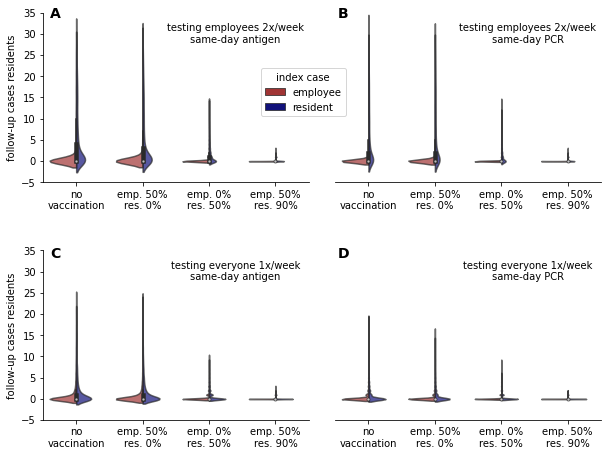

In [98]:
af.plot_violins(ensmbls, 'infected_residents', testing_scenarios[0:4],
             vacc_scenario_labels[0:4], language, ymin=-5, ymax=35,
             variant='_masks')

### Colormaps for different vaccination scenarios

#### Load the simulation results

In [99]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_masks_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [100]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [101]:
N_runs = 5000
sim_name = 'simulations_testing_strategy_masks_{}.csv'.format(N_runs)

In [102]:
no_vacc_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_vacc_data['resident_screen_interval'] = no_vacc_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_screen_interval'] = no_vacc_data['employee_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_vaccination_ratio'] = 0.0
no_vacc_data['resident_vaccination_ratio'] = 0.0

no_vacc_data = no_vacc_data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [103]:
data = pd.concat([data, no_vacc_data])

In [104]:
N_runs = 5000
sim_name = 'simulations_vaccination_rate_masks_{}.csv'.format(N_runs)

In [105]:
no_test_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_test_data['resident_screen_interval'] = no_test_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_test_data['employee_screen_interval'] = no_test_data['employee_screen_interval']\
    .replace(frequency_name_map)

no_test_data = no_test_data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

#### Plots

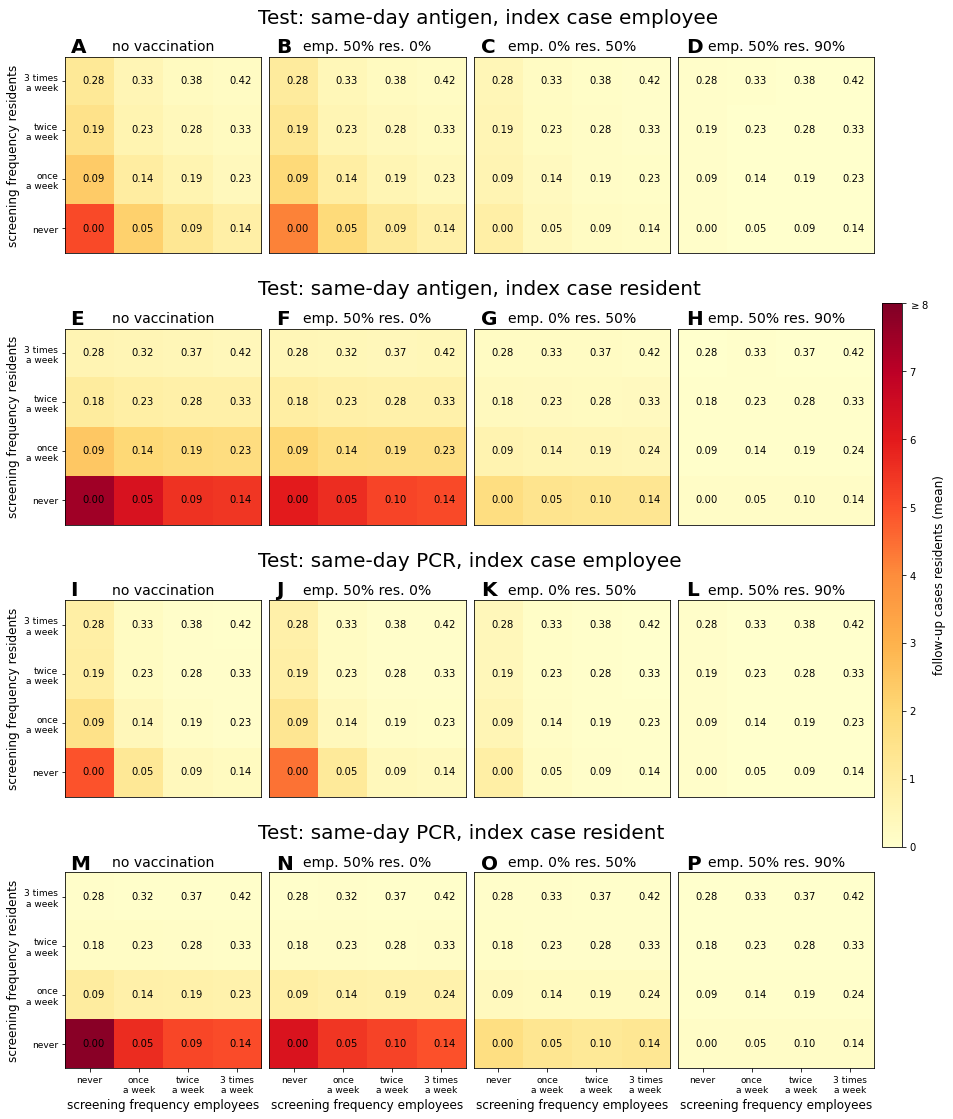

In [106]:
af.plot_testing_strategy_vaccination_scenario_grid(\
    data, 'infected_residents_mean', screening_intervals,
    vaccination_scenarios[0:4], vacc_scenario_labels, language,
    variant='_masks', vmax=8, vstep=1)

### Outbreak sizes

#### Antigen tests & 50% vaccinated residents

In [107]:
mean = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2146 +- 0.9238601320052195


In [108]:
mean = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.3685999999999998 +- 2.1055214755819582


#### PCR tests & 0% vaccinated residents, 0% vaccinated employees

In [109]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3614 +- 2.193844258493776


In [110]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.1412 +- 6.701092708558637


#### PCR tests & 0% vaccinated residents, 50% vaccinated employees

In [111]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3884 +- 2.2368160651295947


In [112]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.1948 +- 6.768250497947057


#### PCR tests & 50% vaccinated residents

In [113]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3614 +- 2.193844258493776


In [114]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.2144 +- 1.927997944816084


#### PCR tests & 90% vaccinated residents, 50% vaccinated employees

In [115]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0072 +- 0.0935409535016422


In [116]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1262000000000001 +- 0.3708113539416537


#### Antigen tests & 90% vaccinated residents, 50% vaccinated employees

In [117]:
mean = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0168 +- 0.1375556044254895


In [118]:
mean = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.14080000000000004 +- 0.3997590792768725


#### No tests & 90% vaccinated residents, 50% vaccinated employees

In [119]:
mean = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_mean']
std = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0678 +- 0.27643886067038


In [120]:
mean = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_mean'] - 1
std = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.15100000000000002 +- 0.4096737317833578
